# Data Injection on Monit
In this tutorial, we will prepare a dataset and sent it to the MonIT infrastructure. We will use Spark to check at the data once it is ingested in HDFS. 

## Requirements

  - A swan environment:
      - If you haven't used swan or cernbox before login first in cernbox to have you eos folder created.
      - go to https://swan.cern.ch, login and create a new session with the following configuration:
            Software stack 96 Python 3
            Platform CentOS 7 (gcc8)
            Number of cores 4
            Memory 8 GB
            Spark cluster Analytix[+]
  - This notebook
        In SWAN, create a new project (using the + button). Enter to the project folder.
        Download this notebook and import it to the new project using the upload file button.
        
[+] Optional, if you want to see your data in HDFS you will need to have access to the Analytix cluster. If you haven't used HDFS at CERN before, you will need to create a [SNOW ticket to the Hadoop service element](https://hadoop-user-guide.web.cern.ch/hadoop-user-guide/getstart/access.html) to have your account authorized. Please specify that you will use the Analytix cluster to access CMS data.  **This will be required to run the Spark part of this tutorial.**

### Before start

To inject data into MonIT we will use the StompAMQ module of the CMSMonitoring package. You can install it using pip:

```
pip install CMSMonitoring
```
In case of swan you will need to install it in the user space, you can do it running the next cell

**Note** As a best practice you *should* use a virtual environment for your application.

In [1]:
# The jupyter magic command will install the package (this notebook was produced with the version 0.3.3)
%pip install --user CMSMonitoring==0.3.3
# As the package is installed in the user space we will need to update the sys.path list 
# to use it. This is only necessary if you don't want to restart the kernel.
# (i.e. you will not need to do this in a script.)
import sys
import site
sys.path.insert(0,site.getusersitepackages())
print(sys.path)

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.
['/eos/user/c/carizapo/.local/lib/python3.6/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib', '/tmp/spark-ba059d9a-9102-42e3-b311-74217ed80409/userFiles-4102d8d5-48f5-4369-aec6-b6b3874159ef', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.6.5-f74f0/x86_64-centos7-gcc8-opt/lib/python36.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.6.5-f74f0/x86_64-centos7-gcc8-opt/lib/python3.6', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.6.5-f74f0/x86_64-centos7-gcc8-opt/lib/python3.6/lib-dynload', '/eos/user/c/carizapo/.local/lib/python3.6/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.6.5-f74f0/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages', '/usr/local/lib/swan/IPython

## Let's start

### What are we doing when we send data to monit? 

In the monit infrastructure we have different ways to send data, the most common one is to use the AMQ enpoint. 

producer --> AMQ endpoint --> flume --> Kafka --> flume --> [HDFS/INFLUXDB/ElasticSearch] --> [Kibana/Grafana/Swan...]

In this tutorial we are creating a new producer. 


In order to send data to AMQ the producer should known the broker, his credentials and the topic where it will store the messages. 

**In this tutorial we will use the training topic and the training user credentials**. When developing your own producer, you should obtain a proper end-point from CERN MONIT team. You can arrange this by opening either a CMSMONIT Jira ticket or a SNOW ticket. The former will be directed to CMS Monitoring group and we'll coordinate its progress with CERN MONIT team, the later will go directly to CERN MONIT line of support and bypass CMS Monitoring. Please choose accordingly. In the ticket you should specify the following mandatory items:

  - The data volume you foresee from your data-provider to CERN MONIT, an approximate numbers are sufficient, e.g. size of JSON document times number of docs per certain time
  - An approximate injection rate, e.g. 1K docs per day
  - You should provide desired topic name where your docs will appear, e.g. cms-my-topic (try always to use the cms prefix followed by your topic name)
  - Your preference for authentication, password based or X509 certificate
  - Provide an e-group which will be used for communication between your team and CERN MONIT

Once you have the appropiated credentials you need to: 

   - Collect your data
   - Transform your data into the required format
   - Send the messages

First we will install the dependecies, we will use StompAMQ from CMSMonitoring and also the json package.

In [2]:
import os
import json
import time
from itertools import islice
from CMSMonitoring.StompAMQ import StompAMQ

### Collect your data

In [3]:
def get_training_data_from_mock_file(samples=100, username=None, location="/eos/user/c/cmsmonit/training/trainingCMSData.json"):
    """
    Get training data from a text file, add to it the timestamp and the username
    and yield it as a dictionary.
    ```
    {
        'id': 1,
        'country': 'BR',
        'tier': 'T0',
        'siteName': 'T0_BR_vermin',
        'requestedCores': 3.39,
        'requestedMB': 1054,
        'usedMB': 1156,
        'training_username': 'training',
        'timestamp': 1583770104.5563471
    }
    ```
    
    If samples is bigger than the actual data it will read again from the start.
    The data was gerenated using mockaroo with the template
    https://mockaroo.com/b01a5310
    """
    if not username:
        username = os.getenv("USER")
    with open(location,"r") as mock_data_file:
        for i in range(0,samples):
            json_line =  mock_data_file.readline()
            if not json_line:
                mock_data_file.seek(0)
                json_line =  mock_data_file.readline()
            data = json.loads(json_line)
            data["training_username"] = username
            data["timestamp"] = time.time()
            yield data
            
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

### Transform and send your data

The StompAMQ module provides you with methods to tranform and send your data in the appropiate format. 
It will requires that you:
  - create a `StompAMQ` instance that will act as your connection to the AMQ broker. 
  - transform your documents using the `make_notification` method
  - send it using the `send`
  
In order to create the StompAMQ instance you will need the producer name, the topic, the host and port of the broker, and the credentials to autenticate. The credentials can be either certificates or username-password pairs. When you are ussing certificates you need to use an empty username and password. 


In [4]:
username = ""
password = ""
producer = "cms-training"
topic = "/topic/cms.training"
host = "cms-test-mb.cern.ch"
port = 61323
cert = "/eos/user/c/cmsmonit/training/.globus/robot-training-cert.pem"
ckey = "/eos/user/c/cmsmonit/training/.globus/robot-training-key.pem"

*tip*: In a notebook you can explore the singature and documentation of any method or class using an `?` after it: 

In [5]:
StompAMQ?

In [6]:
stomp_amq = StompAMQ(username, password, producer, topic, key=ckey, cert=cert, validation_schema=None, host_and_ports=[(host, port)])

In [7]:
stomp_amq.make_notification?

For this tutorial, we will send 1000 messages, in batches of 100 each 10 seconds. 

In [8]:
batch_size = 100
n_messages = 1000
wait_seconds = 10
gen_data = get_training_data_from_mock_file(n_messages)

eod = False
while not eod: 
    messages = []
    for d in take(batch_size, gen_data):
        notif,_,_ = stomp_amq.make_notification(d, "training_document", dataSubfield=None, ts=d["timestamp"])
        messages.append(notif)
    if messages:
        stomp_amq.send(messages)
        time.sleep(wait_seconds)
    else:
        eod = True

Now the messages have been send to the AMQ queue. It will take some seconds to make them available both on ES and HDFS. 

On Kibana we can see the data at  https://monit-kibana.cern.ch/kibana/goto/078e54ae56b3b354ad3328d5e8053a7d

On Grafana you can see the elastic search data using the monit_prod_cms-training datasource, as [you can see in this dashboard](https://monit-grafana.cern.ch/d/_S0CjmuWk/user-carizapo-training_test?orgId=11). 

On HDFS Monit Data is available at `/project/monitoring/archive/<<producer>>/<<prefix>>/<<doc_type>>/<<date yyy/MM/dd>>`, e.g. `/project/monitoring/archive/cms-training/raw/metric/2020/03`. 
**Note**: The current day data in hadoop is not compacted yet, so the day folder will end in `.tmp`.

In [9]:
#In order to make this work you need access to the analytix cluster. 
!hadoop fs -ls "/project/monitoring/archive/cms-training/raw/metric/$(date +'%Y/%m/%d').tmp" 2>/dev/null
!hadoop fs -cat "/project/monitoring/archive/cms-training/raw/metric/$(date +'%Y/%m/%d').tmp/*" 2>/dev/null |head -n1

Found 8 items
-rw-r--r--+  3 monitops hdfs     139717 2020-03-10 11:41 /project/monitoring/archive/cms-training/raw/metric/2020/03/10.tmp/FlumeData.monit-hdfssink-5cf2740dc3.1583833266033
-rw-r--r--+  3 monitops hdfs      13251 2020-03-10 14:20 /project/monitoring/archive/cms-training/raw/metric/2020/03/10.tmp/FlumeData.monit-hdfssink-5cf2740dc3.1583846449466.tmp
-rw-r--r--+  3 monitops hdfs     140727 2020-03-10 11:41 /project/monitoring/archive/cms-training/raw/metric/2020/03/10.tmp/FlumeData.monit-hdfssink-79c09cf15c.1583833269017
-rw-r--r--+  3 monitops hdfs      12219 2020-03-10 14:20 /project/monitoring/archive/cms-training/raw/metric/2020/03/10.tmp/FlumeData.monit-hdfssink-79c09cf15c.1583846447185.tmp
-rw-r--r--+  3 monitops hdfs     139497 2020-03-10 11:41 /project/monitoring/archive/cms-training/raw/metric/2020/03/10.tmp/FlumeData.monit-hdfssink-81f7c441d4.1583833269691
-rw-r--r--+  3 monitops hdfs      17359 2020-03-10 14:20 /project/monitoring/archive/cms-training/raw/metric

# Query the hdfs data from spark

**Note** You only can run this part of the tutorial if you created the Swan environment connected to the Analytix cluster.  
### Introduction to Spark on Swan
Swan will take care of the creation of the spark session/spark context variables. In order to do so you need to start the spark session using the star icon.
![]( 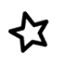)
For this notebook you can start the session using the default configuration. 
Before clicking connect take some time to explore this interface, some useful variables you could set here are:
  - spark.executor.memory
  - spark.driver.memory
  - spark.executor.instances
  - spark.executor.cores
  - spark.sql.shuffle.partitions
  
Once you are connected to the spark session two variables are created for you:
    - `spark`: The spark session
    - `sc`: The spark context
Run the next cell to see more information about them:

In [10]:
display(spark)
display(sc)

<SparkContext master=yarn appName=pyspark_shell_swan>

Also, as you are now connected to a hadoop cluster, you can use the Hadoop (elephant) icon to browse the data in HDFS. Use it to see the available data in `/project/monitoring/archive/cms-training/raw/metric/`




### Reading our data from hdfs 
The data we just send have the following structure:

```json
{
	"metadata": {
		"hostname": "monit-amqsource-42bd3643dc.cern.ch",
		"partition": "9",
		"type_prefix": "raw",
		"kafka_timestamp": 1583833262584,
		"topic": "cms-training_raw_metric",
		"producer": "cms-training",
		"_id": "3c8955e8-8dad-41d1-a68f-3552056ecdb9",
		"type": "metric",
		"version": "001",
		"timestamp": 1583833261994
	},
	"data": {
		"id": 3,
		"country": "ID",
		"tier": "T3",
		"siteName": "T3_ID_afternoon",
		"requestedCores": 4.23,
		"requestedMB": 501,
		"usedMB": 3102,
		"training_username": "carizapo",
		"metadata": {
			"uuid": "3c8955e8-8dad-41d1-a68f-3552056ecdb9"
		}
	}
}
```
Note that our original data is included into the `data` property.

So, the first thing we should do is to define the schema we'll use to read the data in spark. This step is optional but highly recommended, if we don't specify a schema, spark will try to infer the schema reading a sample of the data (even worse, the sampling ratio is 1 by default).

In the schema, we only need to include the fields we will use in the current application.

In [11]:
from pyspark.sql.functions import col
from pyspark.sql.types import StructField, StructType, StringType, LongType, DoubleType
_schema = StructType([
    StructField("metadata", StructType([StructField("timestamp",LongType(), nullable=False)])),
    StructField("data", StructType([
        StructField("country", StringType(), nullable=True),
        StructField("tier", StringType(), nullable=True),
        StructField("siteName", StringType(), nullable=True),
        StructField("requestedMB", DoubleType(), nullable=True),
        StructField("usedMB", DoubleType(), nullable=True),
        StructField("training_username", StringType(), nullable=True),
    ])),
])

Now we can read the json files, in this case we are only interested in the ones we just created, but the path can use glob expressions, or a list, to select multiple directories.

In [12]:
from datetime import datetime
today = datetime.now()
base = "/project/monitoring/archive/cms-training/raw/metric"
training_df = spark.read.json(f"{base}/{today.strftime('%Y/%m/%d')}{{.tmp,}}", schema=_schema)

In [13]:
training_df.printSchema()

root
 |-- metadata: struct (nullable = true)
 |    |-- timestamp: long (nullable = true)
 |-- data: struct (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- tier: string (nullable = true)
 |    |-- siteName: string (nullable = true)
 |    |-- requestedMB: double (nullable = true)
 |    |-- usedMB: double (nullable = true)
 |    |-- training_username: string (nullable = true)



While multiple users can send data to the same datasource, we are only interested in data created by the current user.

In [14]:
training_df = (training_df.where( f"data.training_username == '{os.getenv('USER')}'")
                          .select("metadata.timestamp", "data.*")
              )

Now we want to check the memory efficiency by country/tier/sitename so we can create  a dataframe grouping by those attributes

In [15]:
grouped_df = (training_df.groupBy(["country", "tier", "siteName"])
                         .agg({"requestedMB":"sum", "usedMB":"sum"})
             )

Now we can add the memoryEff column

In [16]:
grouped_df = (grouped_df.withColumnRenamed("sum(usedMB)","used")
                        .withColumnRenamed("sum(requestedMB)","requested")
                        .withColumn("MemoryEff", col("used")/col("requested"))
                        .cache()
             )

In case the memory limits are not enforced, we can look at the sites that get more memory used than requested

In [17]:
overuse_df = grouped_df.orderBy(grouped_df.MemoryEff.desc_nulls_first()).limit(10).toPandas()
display(overuse_df)

,country,tier,siteName,requested,used,MemoryEff
0,PT,T0,T0_PT_lapses,0.0,2209.0,NaN
1,FI,T2,T2_FI_satanic,4.0,2624.0,656.000000
2,PL,T1,T1_PL_lushest,14.0,3468.0,247.714286
3,CN,T3,T3_CN_interlude,10.0,1869.0,186.900000
4,UA,T1,T1_UA_perverted,9.0,1322.0,146.888889
5,RU,T3,T3_RU_chaff,14.0,1480.0,105.714286
6,AR,T3,T3_AR_keened,29.0,3052.0,105.241379
7,PG,T0,T0_PG_steering,17.0,1748.0,102.823529
8,AF,T3,T3_AF_stork's,38.0,3607.0,94.921053
9,GR,T3,T3_GR_polishes,27.0,2477.0,91.740741


Or we can get the ones that get more memory requested than used

In [18]:
overrequest_df = grouped_df.orderBy(grouped_df.MemoryEff.asc_nulls_last()).limit(10).toPandas()
display(overrequest_df)

,country,tier,siteName,requested,used,MemoryEff
0,PH,T3,T3_PH_slant's,1902.0,0.0,0.000000
1,ID,T1,T1_ID_homemade,1742.0,2.0,0.001148
2,PT,T3,T3_PT_compelled,5985.0,18.0,0.003008
3,NG,T2,T2_NG_pagan's,1708.0,6.0,0.003513
4,PT,T3,T3_PT_priest,1344.0,14.0,0.010417
5,CN,T3,T3_CN_virtue's,1105.0,13.0,0.011765
6,PH,T3,T3_PH_longing,532.0,13.0,0.024436
7,CA,T3,T3_CA_fired,1056.0,35.0,0.033144
8,CN,T3,T3_CN_respites,889.0,30.0,0.033746
9,CA,T3,T3_CA_slashed,1984.0,71.0,0.035786
